<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/deep_learning/D2L_Lab_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Learning for MSc - Lab Coding Task 2025

## Preliminary Work

You should have already done Lab 2 ensuring that you read through the actual Python code and understand how the code is working.

You should have also read the start of Chapter 3 of the Dive into Deep Learning (D2L) Book and understood this.

This task has two main Intended Learning Outcomes (ILOs):

1. You should be able to look at Python code similar to Lab 2 Task 1 and understand what all the parts of the code are doing.
2. You should gain an understanding of the structure of the Deep Learning Framework in the D2L Book (and hence the process of doing Deep Learning). This is vital to understand material in later chapters of the book. (Understanding the initial framework is quite difficult but it becomes much easier once it is repeated for different types of deep learning networks.)

## Overall Objective

The notebook below consists of notebook code from Chapter 3 of the D2L book (slightly modified) that synthesizes linear regression data with Gaussian noise and then fits a linear model to it. I have also added the plotting code from Lab 2 so that you can visualize the output of the linear model in terms of original training data, ground-truth function and the function the model learned.

Your overall objective is to change this code so it does the Task 1 in Lab 2.

The final graphical output of the code should look very similar to the output given on Moodle.  

You should then submit the notebook to the Moodle submission site.

This is an individual coursework so you should do it by yourself (without Generative AI or the help of other students!)

If you don't do this coursework by yourself then you will not learn waht is needed, you will find all the subsequent studies harder and it will ultimately affect your overall performance in the final exam.

## Key Tasks

1. Ensure you have done the prerequisites preliminary work given above.
2. Slowly run the notebook cells while you read the notebook cell descriptions and code. Make sure you understand how the code is working and the structure of the framework.
3. Modify the code to generate / synthesize appropriate data as given in Lab 2, Task 1. (Including changing the code to use the same probability distributions as Lab 2 / Task 1.)
4. Modify the code to use the more complicated model given in Lab 2, Task 1. (Hint: Look at D2L Book Chapter 5 to see how this could be done.)
5. **You should modify the template to make your data synthesis, neural network architecture and optimization approach as close to the original Task 1 Lab 2 as possible except: generate 500 training points and 500 validation points, use a batch size of 100 and run 100 epochs.**
6. Look at the results and resolve any issues that might be present. (Some aspects of this task require problem solving and you will need to solve any issues that may arise - potentially including coding issues with this original template code!)
7. Ensure that you have "clean code" and "notebook documentation" - you should remove anything that is not relevant to the new model - and you should update Markdown documentation to reflect how the new code works.
8. **IMPORTANT - You should not change the plotting code !**
9. Upload the notebook of your solution to Moodle.

Good Luck !



# Synthetic Regression Data (Slightly modified from D2L Book Section 3.3)
:label:`sec_synthetic-regression-data`


Machine learning is all about extracting information from data.
So you might wonder, what could we possibly learn from synthetic data?
While we might not care intrinsically about the patterns
that we ourselves baked into an artificial data generating model,
such datasets are nevertheless useful for didactic purposes,
helping us to evaluate the properties of our learning
algorithms and to confirm that our implementations work as expected.
For example, if we create data for which the correct parameters are known *a priori*,
then we can check that our model can in fact recover them.


In [1]:
%matplotlib inline

# !pip install torch==2.0.0
# !pip install torchvision==0.15.1
# !pip install d2l==1.0.3

import random
import torch
from torch import nn

from d2l import torch as d2l

## Generating the Dataset

For this example, we will work in low dimension
for succinctness.
The following code snippet generates 1000 examples
with 1-dimensional features drawn
from a standard normal distribution.
The resulting design matrix $\mathbf{X}$
belongs to $\mathbb{R}^{1000 \times 1}$.
We generate each label by applying
a *ground truth* linear function,
corrupting them via additive noise $\boldsymbol{\epsilon}$,
drawn independently and identically for each example:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}.$$**)

For convenience we assume that $\boldsymbol{\epsilon}$ is drawn
from a standard normal distribution with mean $\mu= 0$
and standard deviation $\sigma = 1.0$.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.DataModule` (introduced in :numref:`oo-design-data`).
It is good practice to allow the setting of any additional hyperparameters.
We accomplish this with `save_hyperparameters()`.
The `batch_size` will be determined later.


In [2]:
import math
import numpy as np

class SyntheticRegressionData(d2l.DataModule):  # @save
    """Synthetic data for nonlinear regression based on the given function."""
    def __init__(self, noise=0.1, num_train=500, num_val=500, batch_size=32):
        super().__init__()
        self.save_hyperparameters()

        n = num_train + num_val
        self.X = torch.rand(n, 1) - 0.5
        epsilon = torch.randn(n, 1) * noise
        self.y = self.ground_truth_function(self.X) + epsilon

    def ground_truth_function(self, x):
        return -torch.sin(10 * math.pi * (x + 0.5) * torch.sin(x ** 3))


Below, we set the true parameters to $\mathbf{w} = [2.0,]$ and $b = 4.2$.
Later, we can check our estimated parameters against these *ground truth* values.


In [3]:
data = SyntheticRegressionData(noise=0.1)

[**Each row in `features` consists of a single scalar value (in the original it was a vector in $\mathbb{R}^2$) and each row in `labels` is a scalar.**]

Let's have a look at the first entry.


In [4]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0.4716]) 
label: tensor([-0.0971])


## Reading the Dataset

Training machine learning models often requires multiple passes over a dataset,
grabbing one minibatch of examples at a time.
This data is then used to update the model.
To illustrate how this works, we
[**implement the `get_dataloader` method,**]
registering it in the `SyntheticRegressionData` class via `add_to_class` (introduced in :numref:`oo-design-utilities`).
It (**takes a batch size, a matrix of features,
and a vector of labels, and generates minibatches of size `batch_size`.**)
As such, each minibatch consists of a tuple of features and labels.
Note that we need to be mindful of whether we're in training or validation mode:
in the former, we will want to read the data in random order,
whereas for the latter, being able to read data in a pre-defined order
may be important for debugging purposes.


In [5]:
# We will use the concise implementation of the data loader given below.

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

To build some intuition, let's inspect the first minibatch of
data. Each minibatch of features provides us with both its size and the dimensionality of input features.
Likewise, our minibatch of labels will have a matching shape given by `batch_size`.


In [6]:
# Fetch a batch of training data
X, y = next(iter(data.get_dataloader(train=True)))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 1]) 
y shape: torch.Size([32, 1])


While seemingly innocuous, the invocation
of `iter(data.train_dataloader())`
illustrates the power of Python's object-oriented design.
Note that we added a method to the `SyntheticRegressionData` class
*after* creating the `data` object.
Nonetheless, the object benefits from
the *ex post facto* addition of functionality to the class.

Throughout the iteration we obtain distinct minibatches
until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us into trouble with real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with sources such as data stored in files,
data received via a stream,
and data generated or processed on the fly.
Next let's try to implement the same method using built-in iterators.

## Concise Implementation of the Data Loader

Rather than writing our own iterator,
we can [**call the existing API in a framework to load data.**]
As before, we need a dataset with features `X` and labels `y`.
Beyond that, we set `batch_size` in the built-in data loader
and let it take care of shuffling examples  efficiently.


In [7]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [8]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

The new data loader behaves just like the previous one, except that it is more efficient and has some added functionality.


In [9]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 1]) 
y shape: torch.Size([32, 1])


For instance, the data loader provided by the framework API
supports the built-in `__len__` method,
so we can query its length,
i.e., the number of batches.


In [10]:
len(data.train_dataloader())

16

## Summary

Data loaders are a convenient way of abstracting out
the process of loading and manipulating data.
This way the same machine learning *algorithm*
is capable of processing many different types and sources of data
without the need for modification.
One of the nice things about data loaders
is that they can be composed.
For instance, we might be loading images
and then have a postprocessing filter
that crops them or modifies them in other ways.
As such, data loaders can be used
to describe an entire data processing pipeline.

As for the model itself, the two-dimensional linear model
is about the simplest we might encounter.
It lets us test out the accuracy of regression models
without worrying about having insufficient amounts of data
or an underdetermined system of equations.
We will put this to good use in the next section.  


# Concise Implementation of Linear Regression (From D2L Book Section 3.5)
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades.
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` classes (available since version 1.8.0).
The latter
allows users to specify *merely*
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient and may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity, we will use such "lazy" layers
whenever we can.


In [11]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):

      super().__init__()
      self.save_hyperparameters()
      # self.net = nn.LazyLinear(1)
      # self.net.weight.data.normal_(0, 0.01)
      # self.net.bias.data.fill_(0)
      Nhidden=10
      self.fc1 = nn.Linear(1, Nhidden)
      self.fc2 = nn.Linear(Nhidden, 1)

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.


In [12]:
import torch.nn.functional as F

@d2l.add_to_class(LinearRegression)  #@save
def forward(self, x):
    x = F.relu(self.fc1(x))  # tanh() or sigmoid()
    # x = F.tanh(self.fc2(x))
    x = self.fc2(x)
    return x

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [13]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [14]:
import torch.optim as optim

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.

**THE FOLLOWING FOUR LINES ARE KEY TO THE FRAMEWORK - MODEL OBJECT, DATA OBJECT, TRAINING OBJECT and then TRAIN.**


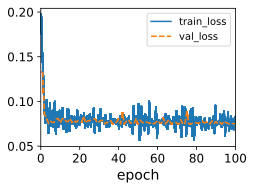

In [19]:
model = LinearRegression(lr=0.01)
data = SyntheticRegressionData(noise=0.1)
trainer = d2l.Trainer(max_epochs=100)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


In [20]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
  return (self.fc1.weight.data, self.fc1.bias.data, self.fc2.weight.data, self.fc2.bias.data)

w1, b1, w2, b2 = model.get_w_b()

w1, b1, w2, b2

(tensor([[-0.1873],
         [ 0.6397],
         [ 0.8945],
         [-0.2525],
         [-0.8640],
         [-0.9948],
         [-0.4020],
         [-0.9192],
         [ 0.3600],
         [ 0.0457]]),
 tensor([ 0.4443,  0.4361,  0.6527, -0.3383, -0.9012,  0.0058, -0.9449,  0.6262,
          0.5379, -0.6474]),
 tensor([[ 0.3499, -0.2043, -0.4611, -0.0177, -0.2175, -0.6666, -0.1003,  0.6431,
          -0.0370,  0.2877]]),
 tensor([-0.1838]))

In [21]:
print(f'Weights of fc1:\n{w1}')
print(f'Bias of fc1:\n{b1}')
print(f'Weights of fc2:\n{w2}')
print(f'Bias of fc2:\n{b2}')

Weights of fc1:
tensor([[-0.1873],
        [ 0.6397],
        [ 0.8945],
        [-0.2525],
        [-0.8640],
        [-0.9948],
        [-0.4020],
        [-0.9192],
        [ 0.3600],
        [ 0.0457]])
Bias of fc1:
tensor([ 0.4443,  0.4361,  0.6527, -0.3383, -0.9012,  0.0058, -0.9449,  0.6262,
         0.5379, -0.6474])
Weights of fc2:
tensor([[ 0.3499, -0.2043, -0.4611, -0.0177, -0.2175, -0.6666, -0.1003,  0.6431,
         -0.0370,  0.2877]])
Bias of fc2:
tensor([-0.1838])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`,
JAX :cite:`Frostig.Johnson.Leary.2018`,
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`,
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.


# Plot sample data, theoretical function and the fitted model function. #

********** **DO NOT MODIFY THE CODE BELOW !** **********


Text(0, 0.5, '$y$')

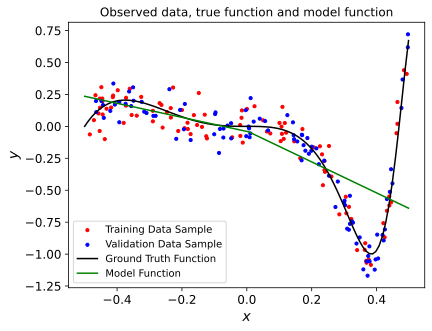

In [24]:

# ********** DO NOT MODIFY THIS CODE ********** #

# ********** IT SHOULD WORK WITHOUT CHANGING THIS CODE ********** #

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

X = data.X.squeeze(1)
y = data.y.squeeze(1)

xgrid = torch.linspace(torch.min(X),torch.max(X),100)

fig = plt.figure()
plt.scatter(X[0:100],y[0:100],10,'r')
plt.scatter(X[100:200],y[100:200],10,'b')

plt.plot(xgrid,data.ground_truth_function(xgrid),'k')
plt.plot(xgrid,model(xgrid.unsqueeze(1)).detach(),'g')

plt.title('Observed data, true function and model function')
plt.legend(['Training Data Sample','Validation Data Sample', 'Ground Truth Function','Model Function'])
plt.xlabel('$x$')
plt.ylabel('$y$')


# Moodle Submission #

Once you modify the code and get the output plot looking like the one shown on Moodle - then please submit your complete notebook to Moodle.



